Packages et fonction pour charger et nettoyer les données ECG et respiratoires

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from physio.preprocess import preprocess, smooth_signal
from physio.parameters import get_respiration_parameters
from physio.respiration import (
    get_respiration_baseline,
    detect_respiration_cycles_crossing_baseline,
    compute_respiration_cycle_features,
    clean_respiration_cycles,
)
from physio.tools import get_empirical_mode
from physio.ecg import compute_ecg
from physio.rsa import compute_rsa
from physio.respiration import compute_respiration



In [6]:
# === Paramètres généraux === #
fs = 100  # Fréquence d'échantillonnage (Hz)
duration_sec = 140  # Durée de la fenêtre en secondes
n_samples = fs * duration_sec

Fonction pour changer les timestamp en seconde

In [7]:
folder_name = "./data/VP"# "./electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0/VP"
folder = lambda x: f"{folder_name}{x:02d}"
resp_file = lambda x: f"{folder(x)}/BitalinoBR.txt"
ecg_file = lambda x: f"{folder(x)}/BitalinoECG.txt"

def timestamp_to_seconds(ts):
    h = np.floor(ts / 10000).astype(int)
    m = np.floor((ts % 10000) / 100).astype(int)
    s = ts % 100
    return h * 3600 + m * 60 + s

Chargement des données et formatage des timestamps en secondes 

In [8]:
resp_data = np.loadtxt(fname=resp_file(2), usecols=(0, 1))
ecg_data = np.loadtxt(fname=ecg_file(2), usecols=(0, 1))

t_resp = timestamp_to_seconds(resp_data[:, 1])
t_ecg = timestamp_to_seconds(ecg_data[:, 1])

Interpolation des données sur le nouveau vecteur temporel

In [9]:
t_start = max(t_ecg[0], t_resp[0])
t_end = min(t_ecg[-1], t_resp[-1])
duration = t_end - t_start
n_interp = int(duration * fs)
t_common = np.linspace(t_start, t_end, n_interp)

interp_resp = interp1d(t_resp, resp_data[:, 0], bounds_error=False, fill_value="extrapolate")
interp_ecg = interp1d(t_ecg, ecg_data[:, 0], bounds_error=False, fill_value="extrapolate")

resp_uniform = interp_resp(t_common)
ecg_uniform = interp_ecg(t_common)

Affichage de la respiration encore bruitée sur une fenêtre de 20 secondes

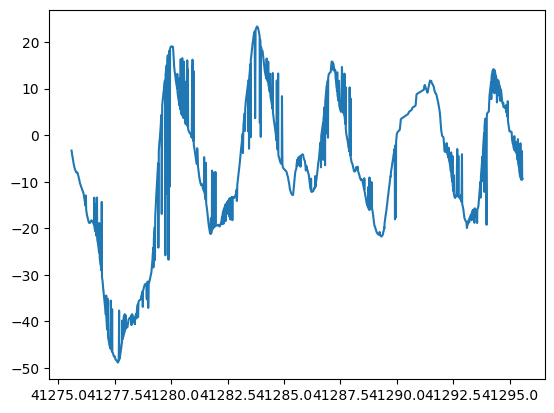

In [10]:
window = slice(20 * fs)
plt.plot(t_common[window], resp_uniform[window])

Prétraitement du signal respiratoire

{'band': 7.0, 'btype': 'lowpass', 'ftype': 'bessel', 'order': 5, 'normalize': False}


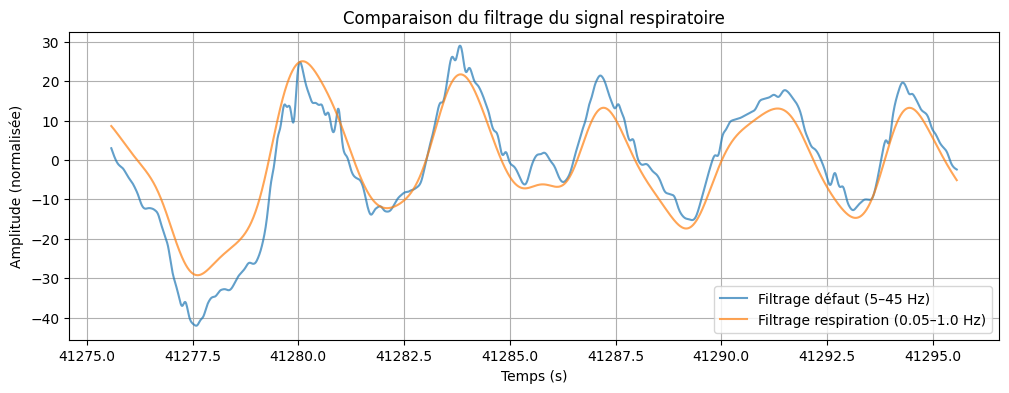

In [11]:
resp_cut = resp_uniform[:n_samples]
t_cut = t_common[:n_samples]
params = get_respiration_parameters('human_airflow')
resp_centered = resp_cut - np.mean(resp_cut)
resp_filtered = preprocess(resp_centered.copy(), fs, **params['preprocess'])
print(params["preprocess"])
# Filtrage personnalisé pour essayer de réduire au max les artéfactes
resp_filtered_custom = preprocess(
    resp_centered.copy(),
    srate=fs,
    band=[0.05, 1],
    btype='bandpass',
    ftype='bessel',
    order=4,
    normalize=False
)
plt.figure(figsize=(12, 4))

plt.plot(t_cut[window], resp_filtered[window], label='Filtrage défaut (5–45 Hz)', alpha=0.7)
plt.plot(t_cut[window], resp_filtered_custom[window], label='Filtrage respiration (0.05–1.0 Hz)', alpha=0.7)
plt.title("Comparaison du filtrage du signal respiratoire")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (normalisée)")
plt.legend()
plt.grid()
plt.show()

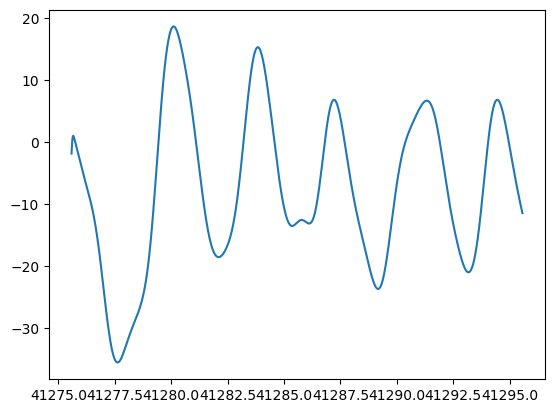

In [12]:
window = slice(20 * fs)
resp_smoothed = smooth_signal(resp_filtered_custom.copy(), fs, **params['smooth'])
resp_preprocessed = resp_smoothed + np.mean(resp_cut)
plt.plot(t_common[window], resp_preprocessed[window])

Pour la détection de cycle, ```physio``` utilise les croisement du signale avec une baseline, ce qui ne correspond pas à des données venant de ceinture piezo. Exemple:

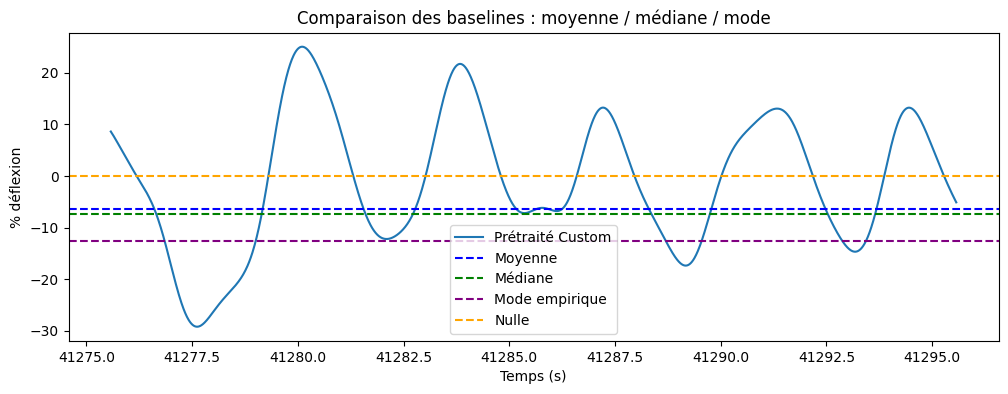

In [13]:
# Différentes baselines
baseline_mean = np.mean(resp_preprocessed)
baseline_median = np.median(resp_preprocessed)
baseline_mode = get_empirical_mode(resp_preprocessed)

plt.figure(figsize=(12, 4))
plt.plot(t_cut[window], resp_filtered_custom[window], label='Prétraité Custom')
plt.axhline(baseline_mean, color='blue', linestyle='--', label='Moyenne')
plt.axhline(baseline_median, color='green', linestyle='--', label='Médiane')
plt.axhline(baseline_mode, color='purple', linestyle='--', label='Mode empirique')
plt.axhline(0, color='orange', linestyle='--', label='Nulle')
plt.legend()
plt.title("Comparaison des baselines : moyenne / médiane / mode")
plt.xlabel("Temps (s)")
plt.ylabel("% déflexion")
plt.show()

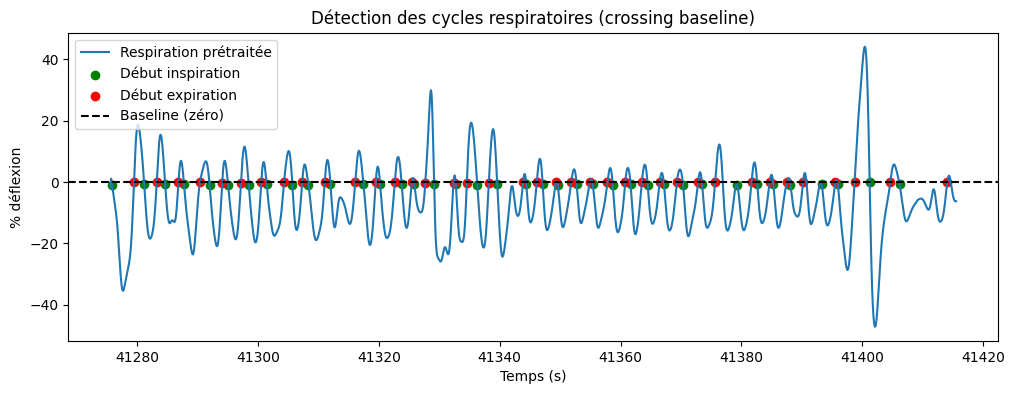

In [14]:
cycles = detect_respiration_cycles_crossing_baseline(
    resp_preprocessed,
    fs,
    baseline_mode='zero',
)

insp_idx = cycles[:, 0]
exp_idx = cycles[:, 1]

plt.figure(figsize=(12, 4))
plt.plot(t_cut, resp_preprocessed, label='Respiration prétraitée')
plt.scatter(t_cut[insp_idx], resp_preprocessed[insp_idx], color='green', marker='o', label="Début inspiration")
plt.scatter(t_cut[exp_idx], resp_preprocessed[exp_idx], color='red', marker='o', label="Début expiration")
plt.axhline(0, color='black', linestyle='--', label='Baseline (zéro)')
plt.legend()
plt.title("Détection des cycles respiratoires (crossing baseline)")
plt.xlabel("Temps (s)")
plt.ylabel("% déflexion")
plt.show()

Ce résultat ne colle pas avec le fait qu'un pique correspond à une haute tension sur la ceinture, suivi d'une détente prograssive de cette dernière, et inversement pour un creux. On va implémenter un efonctio qui va récupérer les maximum et minimum locaux.

In [15]:
from scipy.signal import find_peaks
import numpy as np

def detect_cycles_by_extrema(resp, srate, min_cycle_duration=2.0):
    """
    Détecte les cycles respiration à partir des maxima/minima locaux.
    
    Paramètres
    ----------
    resp : np.array
        Signal respiratoire (filtré).
    srate : float
        Fréquence d'échantillonnage (Hz).
    min_cycle_duration : float
        Durée minimale entre deux inspirations (en secondes).
    
    Retourne
    --------
    cycles : np.array de shape (n, 3)
        Colonnes = [index_inspi, index_expi, next_index_inspi]
    """
    # Durée minimale entre deux inspi (en échantillons)
    min_dist_samples = int(min_cycle_duration * srate)

    # Trouver les pics (maxima) = fins inspiration
    peaks, _ = find_peaks(resp, distance=min_dist_samples)

    # Trouver les creux (minima) = fins expiration → on inverse le signal
    troughs, _ = find_peaks(-resp, distance=min_dist_samples)

    # On garde uniquement les extrema dans l'ordre alterné [trough, peak, trough]
    # [inspi, expi, next_inspi]
    cycles = []
    for i in range(len(troughs) - 1):
        t1 = troughs[i]
        t2 = peaks[(peaks > t1) & (peaks < troughs[i + 1])]
        if len(t2) == 0:
            continue
        t2 = t2[0]  # on prend le premier pic entre les deux creux
        t3 = troughs[i + 1]
        cycles.append([t1, t2, t3])

    return np.array(cycles)


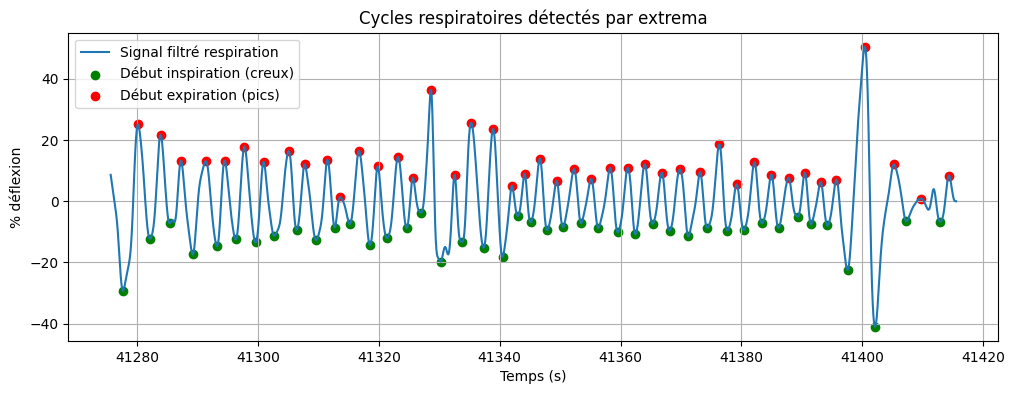

In [16]:
cycles_extrema = detect_cycles_by_extrema(resp_filtered_custom, fs)
window = slice(50)
# Pour affichage :
insp_idx = cycles_extrema[:, 0]
exp_idx  = cycles_extrema[:, 1]

plt.figure(figsize=(12, 4))
plt.plot(t_cut, resp_filtered_custom, label='Signal filtré respiration')
plt.scatter(t_cut[insp_idx], resp_filtered_custom[insp_idx], color='green', label='Début inspiration (creux)')
plt.scatter(t_cut[exp_idx],  resp_filtered_custom[exp_idx],  color='red', label='Début expiration (pics)')
plt.legend()
plt.title("Cycles respiratoires détectés par extrema")
plt.xlabel("Temps (s)")
plt.ylabel("% déflexion")
plt.grid()
plt.show()

On fait maintenant une fonction qui formate l'output \[inspi, expi, next_inspi\] de ```detect_cycles_by_extrema``` pour le rendre compatible avec le calcule du rsa de ```physio```, soit, équivalent à l'output de ```physio.respiration.compute_respiration```.

In [17]:
def convert_cycles_to_dataframe(resp, cycles_array, fs):
    """
    Convertit un tableau [inspi, expi, next_inspi] en DataFrame comme dans physio.
    """
    times = np.arange(len(resp)) / fs
    df = pd.DataFrame()
    df["inspi_index"] = cycles_array[:, 0]
    df["expi_index"] = cycles_array[:, 1]
    df["next_inspi_index"] = cycles_array[:, 2]
    df["inspi_time"] = times[cycles_array[:, 0]]
    df["expi_time"] = times[cycles_array[:, 1]]
    df["next_inspi_time"] = times[cycles_array[:, 2]]
    df["cycle_duration"] = df["next_inspi_time"] - df["inspi_time"]
    df["inspi_duration"] = df["expi_time"] - df["inspi_time"]
    df["expi_duration"] = df["next_inspi_time"] - df["expi_time"]
    df["cycle_ratio"] = df["inspi_duration"] / df["cycle_duration"]
    return df

In [18]:
resp_cycles_custom = convert_cycles_to_dataframe(resp_filtered_custom, cycles_extrema, fs)
# Étape 1 : calcul des features (volumes, durées, amplitudes...)
resp_cycles_custom = compute_respiration_cycle_features(
    resp_filtered_custom,
    fs,
    cycles_extrema,
    baseline=0.0  # tu as centré ton signal, donc c’est cohérent
)

# Étape 2 : nettoyage
resp_cycles_clean = clean_respiration_cycles(
    resp_filtered_custom,
    srate=fs,
    resp_cycles=resp_cycles_custom,
    baseline=0.0
)
# Detection des R pics
ecg, ecg_peaks = compute_ecg(ecg_uniform, fs, parameter_preset='human_ecg')

# Calcul du RSA
points_per_cycle = 50
rsa_cycles, cyclic_cardiac_rate = compute_rsa(
    resp_cycles_custom,  # nos cycles respiration
    ecg_peaks
)


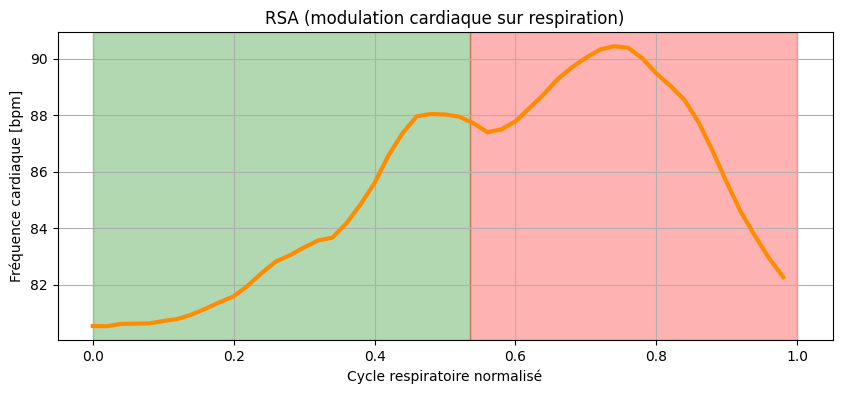

In [19]:
inspi_expi_ratio = np.mean(resp_cycles_custom['inspi_duration'] / resp_cycles_custom['cycle_duration'])
one_cycle = np.arange(points_per_cycle) / points_per_cycle

plt.figure(figsize=(10, 4))
plt.plot(one_cycle, np.mean(cyclic_cardiac_rate, axis=0), color='darkorange', lw=3)
plt.axvspan(0, inspi_expi_ratio, color='g', alpha=0.3)
plt.axvspan(inspi_expi_ratio, 1, color='r', alpha=0.3)
plt.xlabel("Cycle respiratoire normalisé")
plt.ylabel("Fréquence cardiaque [bpm]")
plt.title("RSA (modulation cardiaque sur respiration)")
plt.grid()
plt.show()

test avec exemple de la doc:

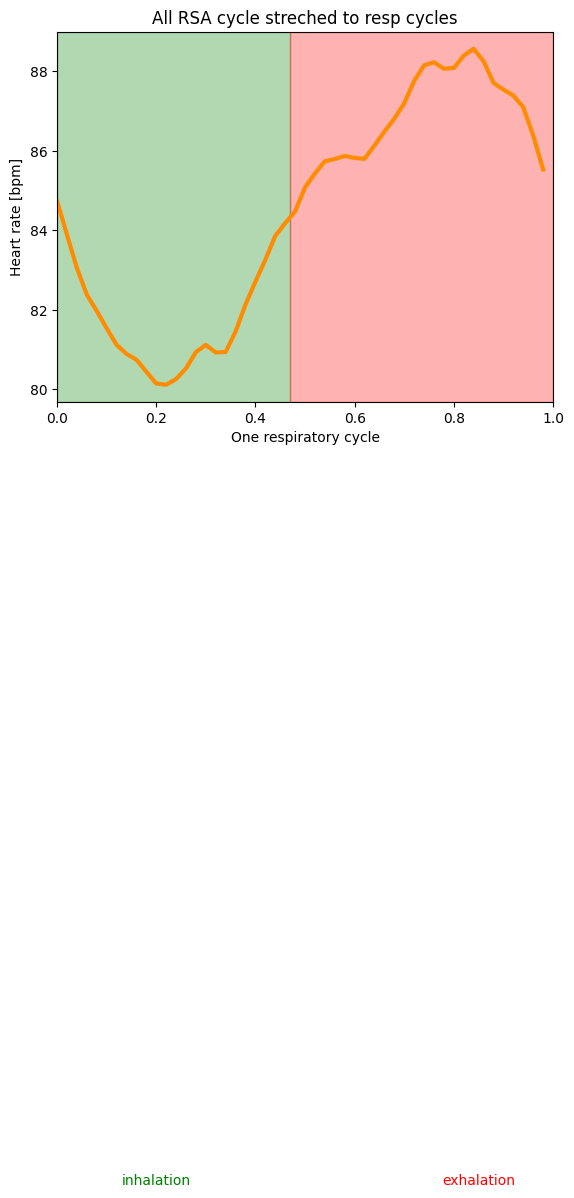

In [20]:
resp, resp_cycles = compute_respiration(resp_uniform, fs, parameter_preset='human_airflow')
ecg, ecg_peaks = compute_ecg(ecg_uniform, fs, parameter_preset='human_ecg')
points_per_cycle = 50

rsa_cycles, cyclic_cardiac_rate = compute_rsa(
    resp_cycles,
     ecg_peaks,
     srate=10.,
     two_segment=True,
     points_per_cycle=points_per_cycle,
)

inspi_expi_ratio = np.mean(resp_cycles['inspi_duration'] / resp_cycles['cycle_duration'])

one_cycle = np.arange(points_per_cycle) / points_per_cycle
fig, ax = plt.subplots()
#ax.plot(one_cycle, cyclic_cardiac_rate.T, color='k', alpha=.3)
ax.plot(one_cycle, np.mean(cyclic_cardiac_rate, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_expi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_expi_ratio, 1, color='r', alpha=0.3)
ax.set_xlabel('One respiratory cycle')
ax.set_ylabel('Heart rate [bpm]')
ax.set_xlim(0, 1)
ax.text(0.2, 60, 'inhalation', ha='center', color='g')
ax.text(0.85, 60, 'exhalation', ha='center', color='r')
ax.set_title('All RSA cycle streched to resp cycles')


plt.show()